Notebook to perform a binary classification of images of Pizza and steak.

1. Downloading the zip file, extracting the contents and removing unwanted parts.

In [2]:
import zipfile
import urllib.request
import shutil

print('Beginning file download with urllib...')

#Downloading
url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip'
urllib.request.urlretrieve(url, 'pizza_steak.zip')

#File Extraction
with zipfile.ZipFile("pizza_steak.zip","r") as zip_ref:
    zip_ref.extractall()

#Removing the unwanted folder(s)
file_path = '__MACOSX'
shutil.rmtree(file_path)

Beginning file download with urllib...


2. Looking at the content inside the extraction

In [8]:
import os
len(os.listdir('pizza_steak/train/pizza')), len(os.listdir('pizza_steak/train/steak'))
for root, dirs, files in os.walk("pizza_steak/"):
  print(f"There are {len(dirs)} directories and {len(files)} images in {root}. ")


#Class names for the binary classification
Class_names = sorted(os.listdir('pizza_steak/train/'))[1:]
Class_names

There are 2 directories and 1 images in pizza_steak/. 
There are 2 directories and 1 images in pizza_steak/test. 
There are 0 directories and 250 images in pizza_steak/test\pizza. 
There are 0 directories and 250 images in pizza_steak/test\steak. 
There are 2 directories and 1 images in pizza_steak/train. 
There are 0 directories and 750 images in pizza_steak/train\pizza. 
There are 0 directories and 750 images in pizza_steak/train\steak. 


['pizza', 'steak']

3. Visualizing a single image

Image shape: (306, 512, 3)


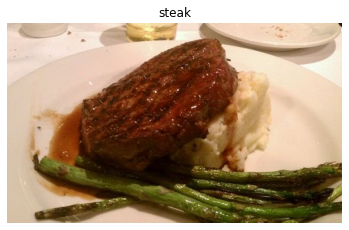

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  print(f"Image shape: {(img.shape)}")
  return img
img = view_random_image('pizza_steak/train/', 'steak')

4. Preprocessing data with tf.keras.preprocessing.image.ImageDataGenerator
    - Here the data is augmented

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255., 
                             rotation_range=20,  
                             shear_range=0.2, 
                             zoom_range=0.2,
                            width_shift_range=0.2,
                             height_shift_range=0.0,
                             horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_dir = 'pizza_steak/train'
test_dir = 'pizza_steak/test'

train_data = train_datagen.flow_from_directory(directory = train_dir, target_size=(224, 224), class_mode='binary',  batch_size=32, shuffle = True)
test_data = test_datagen.flow_from_directory(directory = test_dir, target_size=(224, 224), class_mode='binary',  batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


5. A simple tensorflow model to perform classification

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

tf.random.set_seed(42)

model_1 = Sequential([
        Conv2D (filters = 30, kernel_size = (3,3), activation= 'relu', input_shape = (224,224,3)),
        MaxPool2D(pool_size=(2, 2), padding='valid'),
        Dense(50, activation='relu'),

        Conv2D(filters=30,  kernel_size = (3,3), activation= 'relu'),
        MaxPool2D(pool_size=(2, 2), padding='valid'),
        Dense(50, activation='relu'),

        Conv2D(filters=30,  kernel_size = (3,3), activation= 'relu'),
        MaxPool2D(pool_size=(2, 2), padding='valid'),
        Dense(50, activation='relu'),

        Flatten(),
        Dense(1, activation='sigmoid')                 
])


callback_1 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=0)
callback_2 = tf.keras.callbacks.ModelCheckpoint(filepath='model/model_1-epoch-{epoch:02d}-val_loss-{val_loss:.4f}.h5', save_weights_only=False, verbose=0)

model_1.compile(loss = 'binary_crossentropy', optimizer = Adam(), metrics = ['accuracy'])
history = model_1.fit(train_data, epochs = 15, callbacks=[callback_1, callback_2], steps_per_epoch = len(train_data), validation_data = test_data, shuffle=True, use_multiprocessing=False, validation_steps = len(test_data))


Epoch 1/15
47/47 [==============================] - 65s 1s/step - loss: 0.6040 - accuracy: 0.6780 - val_loss: 0.4514 - val_accuracy: 0.7920
Epoch 2/15
47/47 [==============================] - 48s 1s/step - loss: 0.4869 - accuracy: 0.7747 - val_loss: 0.3759 - val_accuracy: 0.8360
Epoch 3/15
47/47 [==============================] - 50s 1s/step - loss: 0.4589 - accuracy: 0.7900 - val_loss: 0.5170 - val_accuracy: 0.7300
Epoch 4/15
47/47 [==============================] - 49s 1s/step - loss: 0.4628 - accuracy: 0.7940 - val_loss: 0.3837 - val_accuracy: 0.8420
Epoch 5/15
47/47 [==============================] - 49s 1s/step - loss: 0.4537 - accuracy: 0.8087 - val_loss: 0.3317 - val_accuracy: 0.8840
Epoch 6/15
47/47 [==============================] - 49s 1s/step - loss: 0.4294 - accuracy: 0.8067 - val_loss: 0.3351 - val_accuracy: 0.8700
Epoch 7/15
47/47 [==============================] - 54s 1s/step - loss: 0.3994 - accuracy: 0.8187 - val_loss: 0.3045 - val_accuracy: 0.8800
Epoch 8/15
47/47 [==

6. Plotting history curves
    - Seems like model at epoch 5 is the best pick as it had the highest accuracy on validation data.

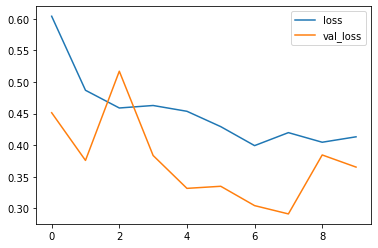

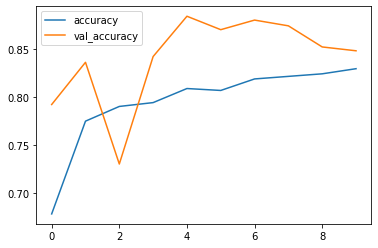

In [7]:
plt.figure()
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(['loss', 'val_loss'])
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

7. Loading the best model and making predictions

In [6]:
model_load = tf.keras.models.load_model('model\model_1-epoch-05-val_loss-0.3317.h5')

But first we need to find a way to relate labels witht the predictions. This can be done by making prediction on a single image.

prediction value by the model 0.9219760894775391
value closer to zero indicated a pizza and closer to one cossreponds to steak


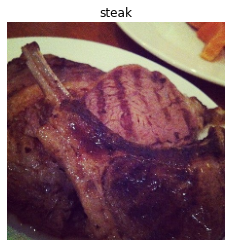

In [9]:
from tensorflow.keras.preprocessing import image

def predict_single_image(img_path):
  img = mpimg.imread(img_path)
  img = tf.image.resize(img, (224,224))
  img = img/255.
  
  pred = tf.squeeze(model_load.predict(tf.expand_dims(img, axis=0)))
  print(f"prediction value by the model {pred}")
  pred = int(tf.round(pred))
  print("value closer to zero indicated a pizza and closer to one cossreponds to steak")
  plt.title(Class_names[pred])
  plt.imshow(img)
  plt.axis('off')
  return img

#Make sure to include \\ for path directories as a single slash for \train might be intrepreted as a tab space.
#change the directory for other samples
path = "pizza_steak\\train\\steak\\"
img = predict_single_image(path + random.choice(os.listdir(path)))

8. Now we can label the whole set

In [54]:
test_features, test_labels = test_data.next()
predictions_labels = tf.round(tf.squeeze(model_load.predict(test_features)))
#predictions_labels

9. Calculating the confusion matrix

In [55]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(test_labels, predictions_labels).ravel()
tn, fp, fn, tp

(19, 0, 1, 12)

Seems like model performed with high accuracy and precision as only 1 images out of 32 images were misclassified. Lets find out which images were misclassified.

In [56]:
tf.where(tf.squeeze([predictions_labels != test_labels]))

<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[13]], dtype=int64)>

test label: steak
pred label: pizza


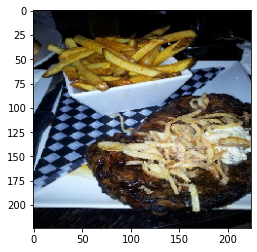

In [57]:
plt.imshow(test_features[13])
print('test label:', Class_names[int(test_labels[13])])
print('pred label:', Class_names[int(predictions_labels[13])])
plt.show()



Both of these images were misclassified by the model. (Guessing) The reason might be the circular shape of the dish. The model might have mistaken it as a pizza.